In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.model_selection import KFold
from sklearn import cross_validation, metrics
from sklearn.metrics import roc_auc_score
import scipy.special as special
from sklearn.externals import joblib
import gc, os
import datetime
import pickle

/root/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sample_path = '../data/sample_data/'
raw_path = '../data/raw_data/'
f = open(sample_path + 'train_x_sample.pkl', 'rb')
train_x = pickle.load(f)
f.close()
train_y = pd.read_csv(sample_path + 'train_y_sample.csv')
print (train_x.shape, train_y.shape)

(1759763, 4312) (1759763, 1)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, train_size=0.1, random_state=2018)

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [2]:
train_xgb_leaf = pd.read_csv('../data/train_topN_and_xgb_feature.csv')
test_xgb_leaf = pd.read_csv('../data/test_topN_and_xgb_feature.csv')

In [5]:
train_id=pd.read_csv('../data/train.csv')[['aid','uid']]
predict_id=pd.read_csv('../data/test1.csv')[['aid','uid']]

In [7]:
train_id.head()

,aid,uid
0,699,78508957
1,1991,3637295
2,1119,19229018
3,2013,79277120
4,692,41528441


In [8]:
train_xgb_leaf = pd.concat([train_id, train_xgb_leaf], axis=1)
test_xgb_leaf = pd.concat([predict_id, test_xgb_leaf], axis=1)

In [10]:
train_xgb_leaf.to_csv('../data/train_xgb_feature.csv')
test_xgb_leaf.to_csv('../data/test_xgb_feature.csv')

In [3]:
data = pd.read_csv('../data/sample_train.csv')

In [ ]:
train_x = sparse.load_npz('../data/train_gen.npz')
test_y = sparse.load_npz('../data/test_gen.npz')

In [3]:
train_y=data.pop('label')
train = data

In [19]:
train_copy = train
train_copy = train_copy.replace('-1', np.NaN)

In [14]:
# 缺失值
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_rate = missings / float(train.shape[0])

        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_rate))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable LBS has 1 records (0.00%) with missing values
Variable house has 71974 records (81.80%) with missing values
In total, there are 2 variables with missing values


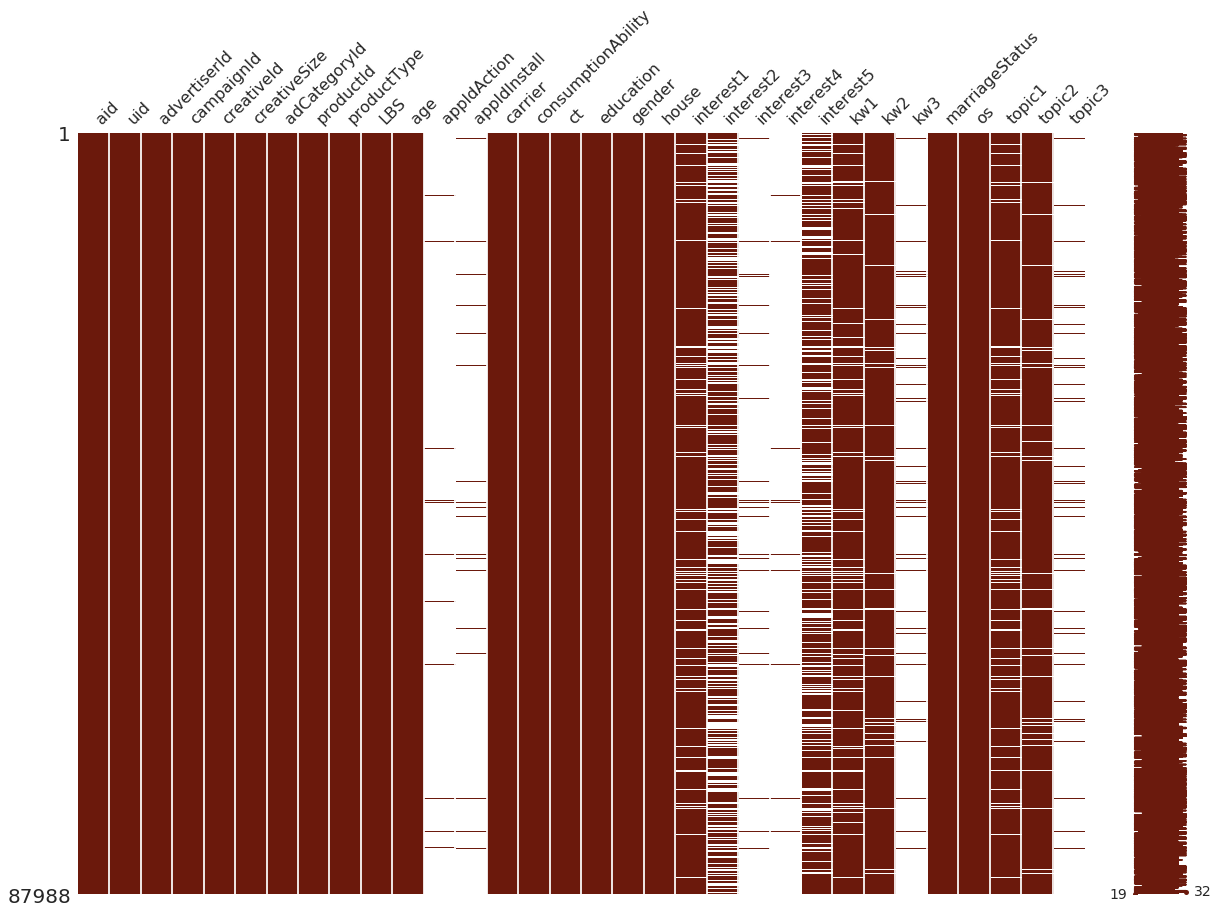

In [21]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy, figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [4]:
encode_feat = []
for f in train.columns:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))
    if dist_values>30:
        encode_feat.append(f)

Variable aid has 173 distinct values
Variable uid has 87851 distinct values
Variable advertiserId has 79 distinct values
Variable campaignId has 138 distinct values
Variable creativeId has 173 distinct values
Variable creativeSize has 15 distinct values
Variable adCategoryId has 40 distinct values
Variable productId has 33 distinct values
Variable productType has 4 distinct values
Variable LBS has 452 distinct values
Variable age has 6 distinct values
Variable appIdAction has 1240 distinct values
Variable appIdInstall has 1732 distinct values
Variable carrier has 4 distinct values
Variable consumptionAbility has 3 distinct values
Variable ct has 64 distinct values
Variable education has 8 distinct values
Variable gender has 3 distinct values
Variable house has 2 distinct values
Variable interest1 has 61675 distinct values
Variable interest2 has 24612 distinct values
Variable interest3 has 149 distinct values
Variable interest4 has 149 distinct values
Variable interest5 has 62572 distin

In [2]:
cross_fea_list = ['productType', 'age', 'education', 'creativeSize', 'consumptionAbility', 'marriageStatus', 'carrier', 'os']

In [5]:
cross_2fea_list = []
for i in range(len(cross_fea_list)):
    for j in range(i+1, len(cross_fea_list)):
        cross_2fea_list.append((cross_fea_list[i], cross_fea_list[j]))

[('productType', 'age'),
 ('productType', 'education'),
 ('productType', 'creativeSize'),
 ('productType', 'consumptionAbility'),
 ('productType', 'marriageStatus'),
 ('productType', 'carrier'),
 ('productType', 'os'),
 ('age', 'education'),
 ('age', 'creativeSize'),
 ('age', 'consumptionAbility'),
 ('age', 'marriageStatus'),
 ('age', 'carrier'),
 ('age', 'os'),
 ('education', 'creativeSize'),
 ('education', 'consumptionAbility'),
 ('education', 'marriageStatus'),
 ('education', 'carrier'),
 ('education', 'os'),
 ('creativeSize', 'consumptionAbility'),
 ('creativeSize', 'marriageStatus'),
 ('creativeSize', 'carrier'),
 ('creativeSize', 'os'),
 ('consumptionAbility', 'marriageStatus'),
 ('consumptionAbility', 'carrier'),
 ('consumptionAbility', 'os'),
 ('marriageStatus', 'carrier'),
 ('marriageStatus', 'os'),
 ('carrier', 'os')]

In [7]:
pd.read_csv('../data/fea_imp.csv', header=None)

,0,1
0,uid,598
1,aid,222
2,creativeSize,126
3,education_2,56
4,consumptionAbility_2,56
5,age_2,51
6,ct_3 1,49
7,education_7,49
8,consumptionAbility_0,47
9,marriageStatus_10,45


In [ ]:
gc.collect()

data = train
for feature in one_hot_feature:
    try:
        data[feature] = LabelEncoder().fit_transform(data[feature].apply(int))
    except:
        data[feature] = LabelEncoder().fit_transform(data[feature])

print (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print('-----------------------LabelEncoder feature data Down-----------')
gc.collect()
output = open(raw_data_path+ "LabelEncode_data.pkl", 'wb')    
pickle.dump(data, output, protocol=4)
output.close()
print('-----------------------LabelEncoder feature data Saved-----------')

In [7]:
# for fea1, fea2, fea3 in cross_3fea:
#     fea1_fea2_fea3 = cross_3feat(train, fea1, fea2, fea3)
#     train[fea1_fea2_fea3.name] = fea1_fea2_fea3
#     one_hot_feature.append((fea1_fea2_fea3.name))
# for fea1, fea2 in cross_2fea:
#     fea1_fea2 = cross_feat(train, fea1, fea2)
#     train[fea1_fea2.name] = fea1_fea2
#     one_hot_feature.append(fea1_fea2.name)


# # In[18]:
# gc.collect()

# data = train
# for feature in one_hot_feature:
#     try:
#         data[feature] = LabelEncoder().fit_transform(data[feature].apply(int))
#     except:
#         data[feature] = LabelEncoder().fit_transform(data[feature])

# print (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
# print('-----------------------LabelEncoder feature data Down-----------')
# gc.collect()
# output = open(raw_data_path+ "LabelEncode_data.pkl", 'wb')    
# pickle.dump(data, output, protocol=4)
# output.close()
# print('-----------------------LabelEncoder feature data Saved-----------')


7    31313
2    22269
6    15183
1    10609
3     4075
5     2844
4      917
0      778
Name: education, dtype: int64

In [6]:
    for feature in one_hot_feature:
        try:
            data[feature] = LabelEncoder().fit_transform(data[feature].apply(int))
        except:
            data[feature] = LabelEncoder().fit_transform(data[feature])

    print (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('-----------------------LabelEncoder feature data Down-----------')

    output = open(raw_data_path+ "LabelEncode_data.pkl", 'wb')    
    pickle.dump(data, output, protocol=4)
    output.close()
    print('-----------------------LabelEncoder feature data Saved-----------')